[<Figure size 800x600 with 1 Axes>,
 <Figure size 800x600 with 1 Axes>,
 <Figure size 800x600 with 1 Axes>]

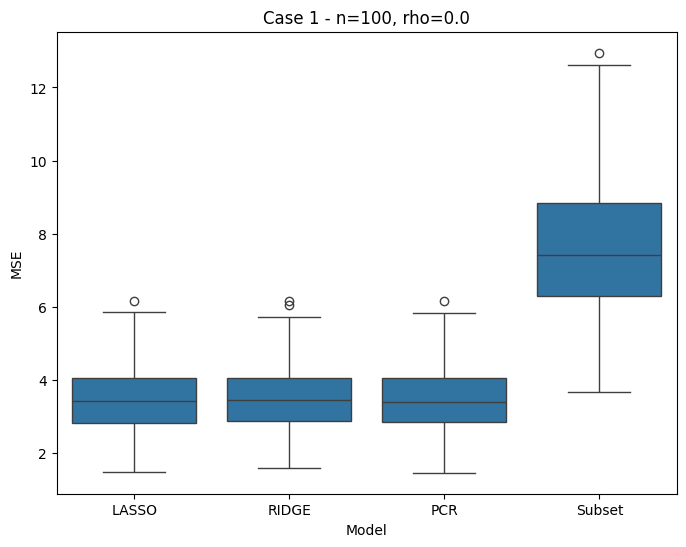

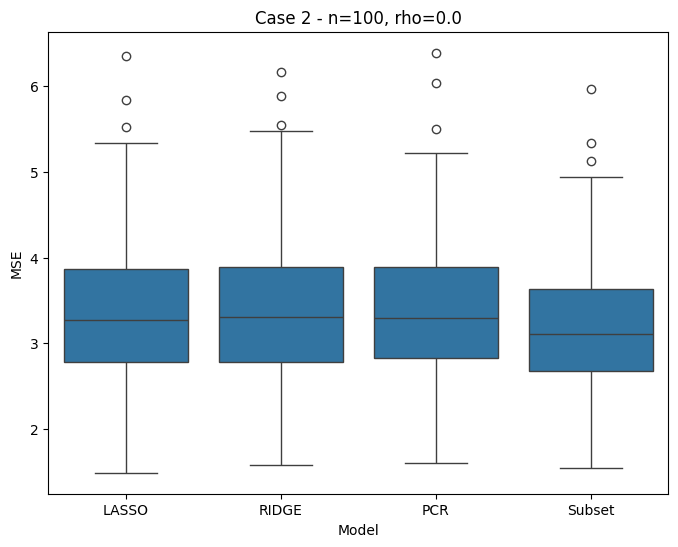

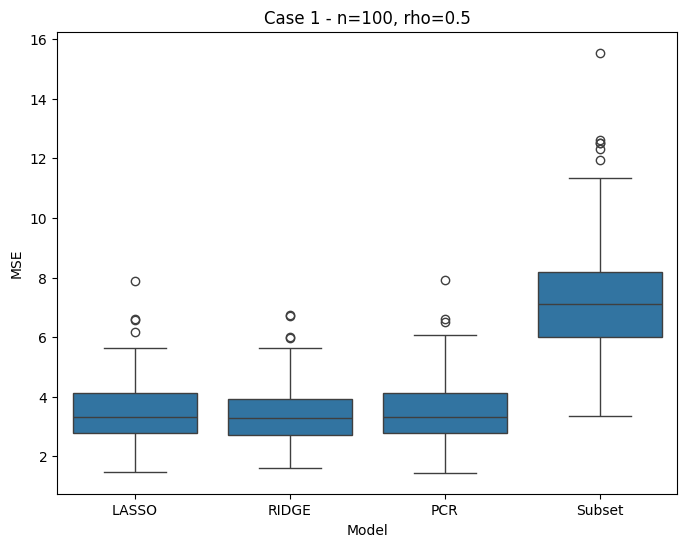

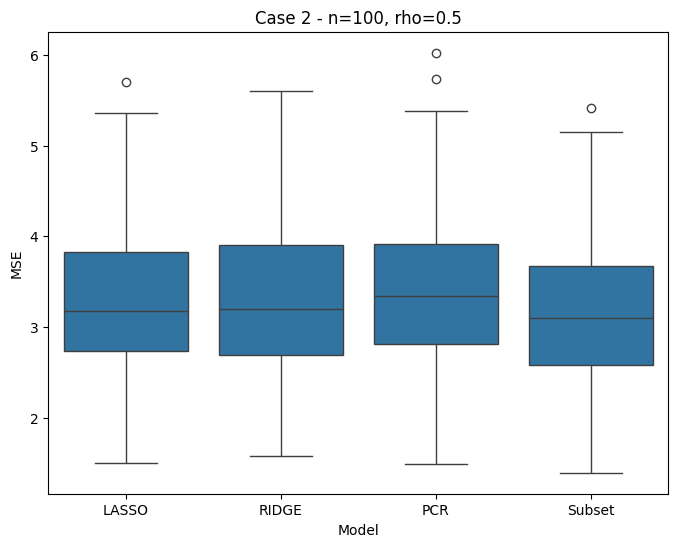

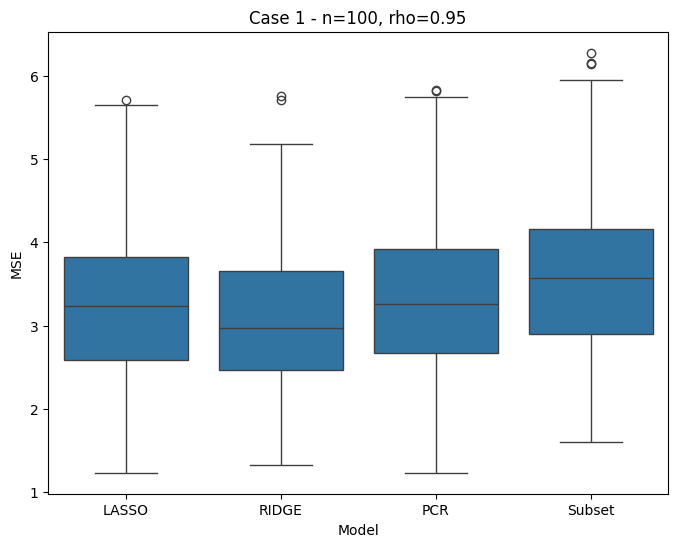

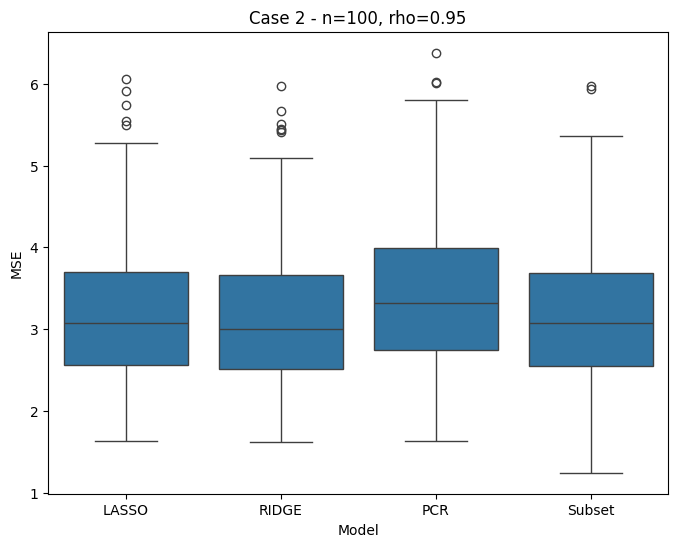

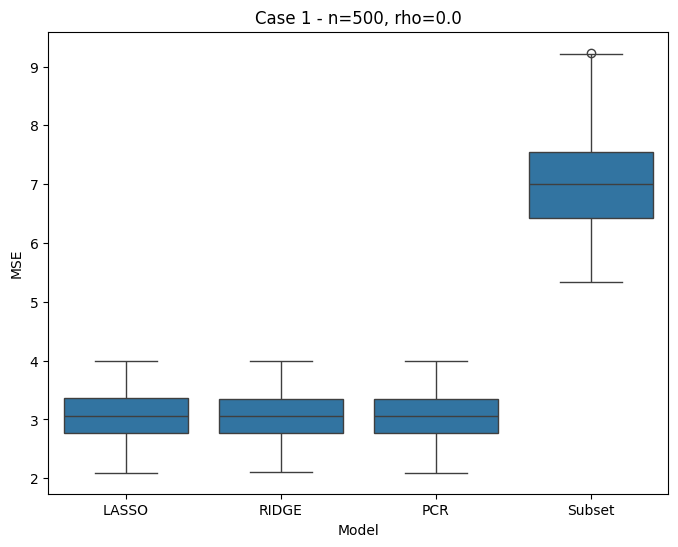

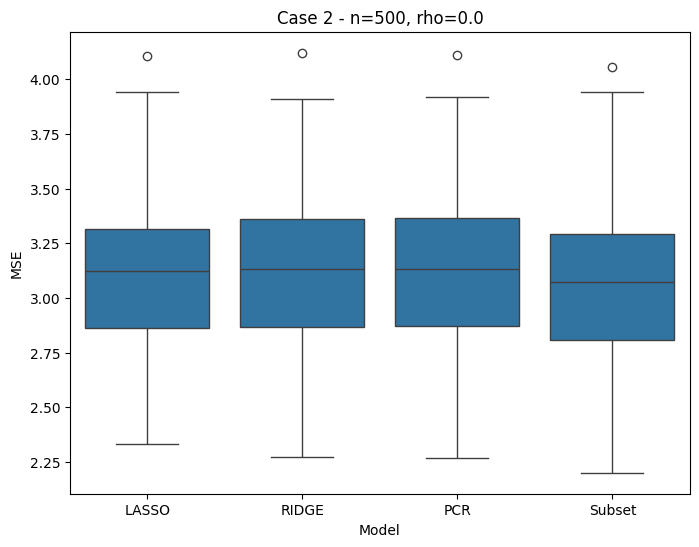

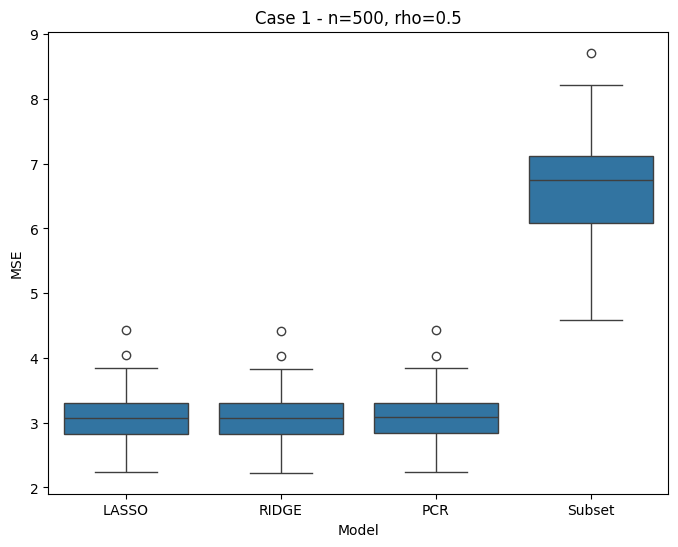

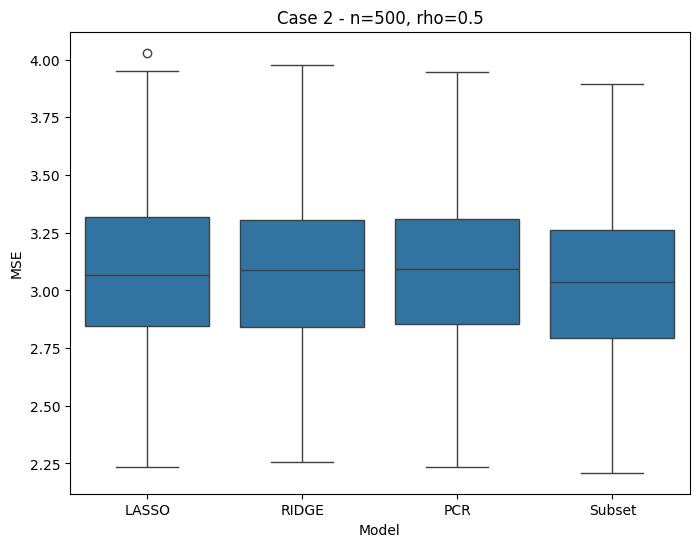

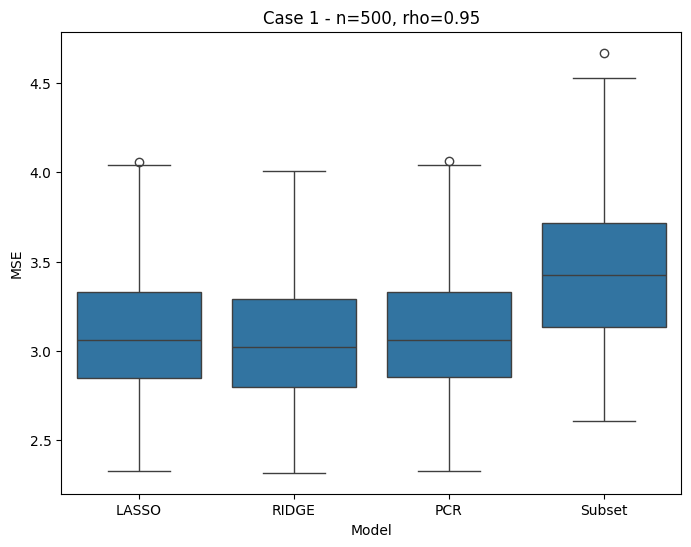

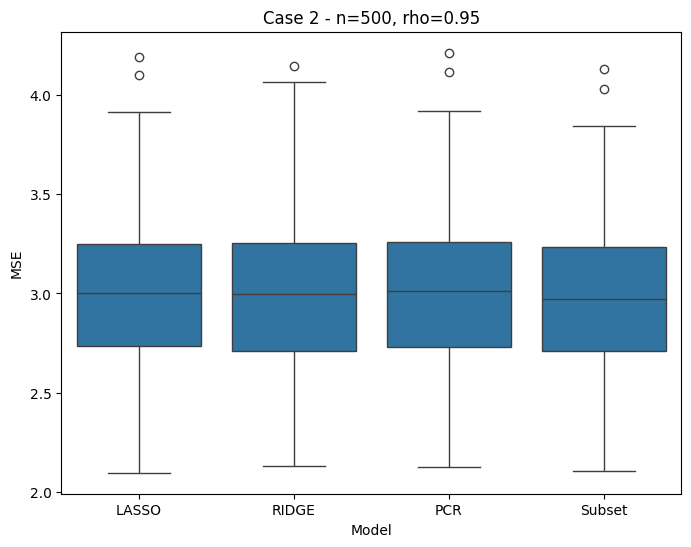

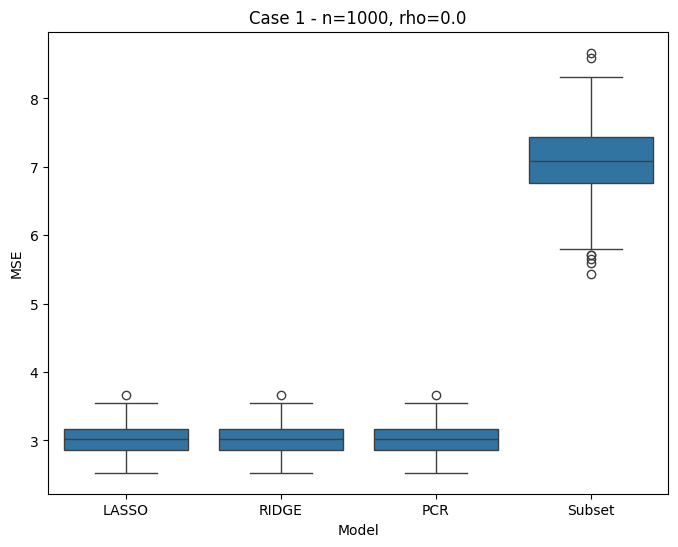

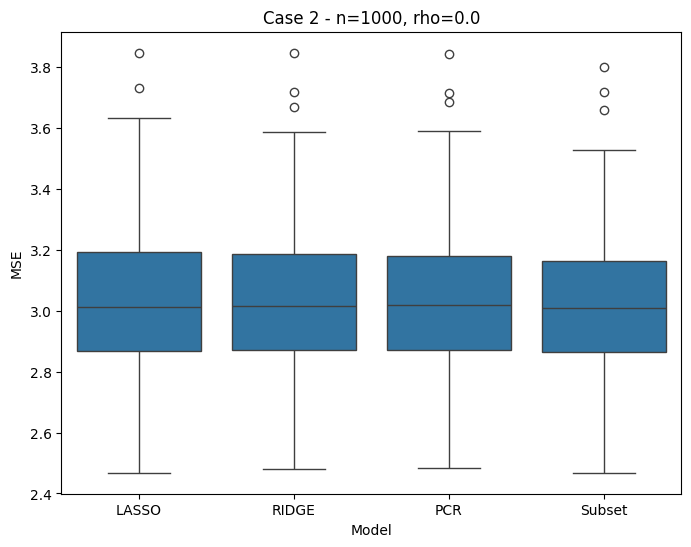

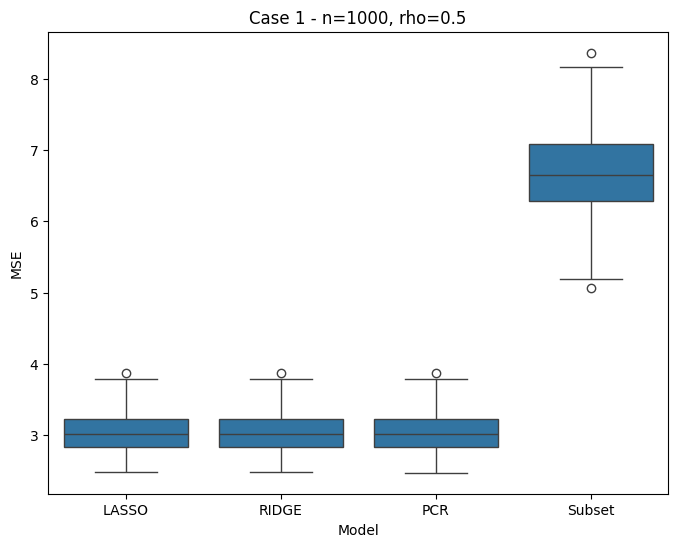

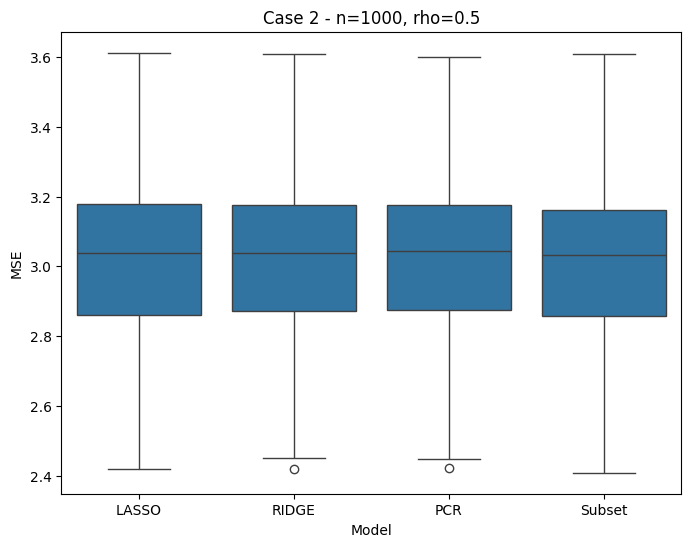

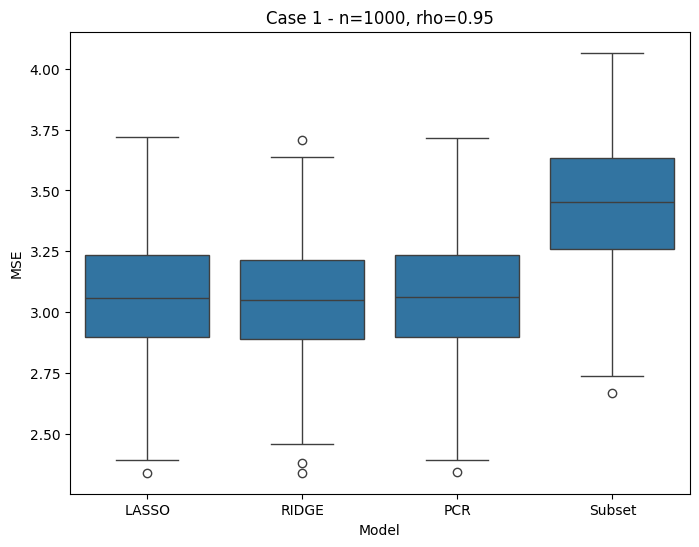

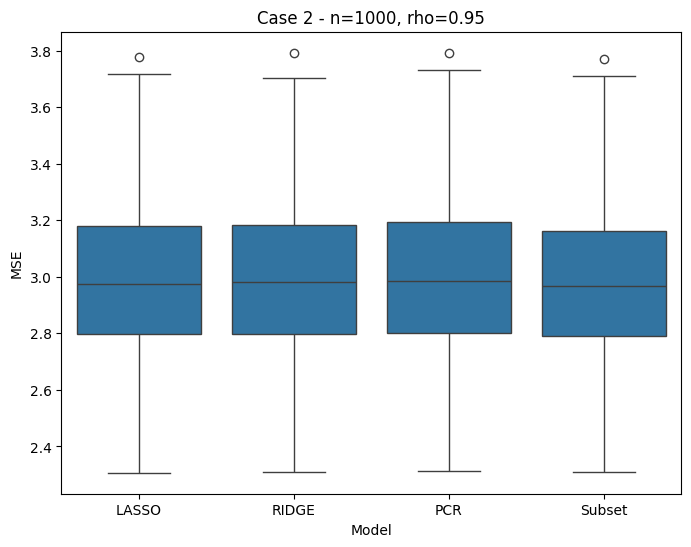

In [ ]:
# Let's run the provided script and capture the outputs, especially the plots.

import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set parameters
n_list = [100, 500, 1000]
p = 8
rho_values = [0, 0.5, 0.95]
n_simulations = 200
sigma_eps = np.sqrt(3)

# Define beta vectors
beta_case1 = np.ones(p)
beta_case2 = np.array([1, 1, 1, 1, 0, 0, 0, 0])

# Helper to create covariance matrix
def create_cov_matrix(p, rho):
    return rho * np.ones((p, p)) + (1 - rho) * np.eye(p)

# Placeholder for results
results = []

# Run simulations
for n in n_list:
    for rho in rho_values:
        Sigma_X = create_cov_matrix(p, rho)
        for case, beta in zip(['Case 1', 'Case 2'], [beta_case1, beta_case2]):
            mse_lasso, mse_ridge, mse_pcr, mse_subset = [], [], [], []

            for sim in range(n_simulations):
                X = np.random.multivariate_normal(np.zeros(p), Sigma_X, n)
                epsilon = np.random.normal(0, sigma_eps, n)
                y = X @ beta + epsilon

                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

                # LASSO
                lasso = LassoCV(cv=5).fit(X_train, y_train)
                y_pred_lasso = lasso.predict(X_test)
                mse_lasso.append(mean_squared_error(y_test, y_pred_lasso))

                # RIDGE
                ridge = RidgeCV(cv=5).fit(X_train, y_train)
                y_pred_ridge = ridge.predict(X_test)
                mse_ridge.append(mean_squared_error(y_test, y_pred_ridge))

                # PCR (using all components)
                pca = PCA().fit(X_train)
                X_train_pca = pca.transform(X_train)
                X_test_pca = pca.transform(X_test)
                linreg = LinearRegression().fit(X_train_pca, y_train)
                y_pred_pcr = linreg.predict(X_test_pca)
                mse_pcr.append(mean_squared_error(y_test, y_pred_pcr))

                # Subset regression (fit only on first 4 predictors)
                linreg_subset = LinearRegression().fit(X_train[:, :4], y_train)
                y_pred_subset = linreg_subset.predict(X_test[:, :4])
                mse_subset.append(mean_squared_error(y_test, y_pred_subset))

            # Collect results
            results.append(pd.DataFrame({
                'Model': ['LASSO'] * n_simulations + ['RIDGE'] * n_simulations +
                         ['PCR'] * n_simulations + ['Subset'] * n_simulations,
                'MSE': mse_lasso + mse_ridge + mse_pcr + mse_subset,
                'n': n, 'rho': rho, 'Case': case
            }))

# Combine all results
all_results = pd.concat(results, ignore_index=True)

# Prepare to collect figures instead of displaying them
plots = []
for (n, rho, case), df_group in all_results.groupby(['n', 'rho', 'Case']):
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.boxplot(x='Model', y='MSE', data=df_group, ax=ax)
    ax.set_title(f'{case} - n={n}, rho={rho}')
    plots.append(fig)

plots[:3]  # Show first few plots for preview
